In [480]:
import torch
import numpy as np
from idem_net_mnist import IdemNetMnist
from data_loader import load_MNIST
import matplotlib.pyplot as plt

In [481]:
run_id = "mnist20241113-115000"
epoch_num = "final.pth"

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


checkpoint_path = f"checkpoints/{run_id}/{epoch_num}"
device

device(type='mps')

In [482]:
model = IdemNetMnist()

state_dict = torch.load(checkpoint_path, weights_only=True, map_location=device)
# state_dict = state_dict["model_state_dict"]

In [483]:
model.load_state_dict(state_dict)
#model.eval()

<All keys matched successfully>

In [484]:
def plot_generation(inputs, outputs, outputs2, num_images=5):
    """
    Plots input and output image pairs side by side.
    
    Parameters:
    - inputs: Batch of input images, expected shape (batch_size, height, width).
    - outputs: Batch of output images, expected shape (num_applications, batch_size, height, width).
    - num_images: Number of image pairs to display (default is 5).
    """
    # Limit the number of images to the smaller of num_images or batch size
    num_images = min(num_images, len(inputs), len(outputs))
    
    plt.figure(figsize=(8, num_images * 3))
    for i in range(num_images):
        # Plot input image
        plt.subplot(num_images, 3, 2 * i + 1)
        plt.imshow(inputs[i].squeeze().detach().numpy(), cmap='gray')
        plt.title("Input")
        plt.axis('off')
        
        # Plot output image
        plt.subplot(num_images, 3, 2 * i + 2)
        plt.imshow(outputs[i].squeeze().detach().numpy(), cmap='gray')
        plt.title("Output")
        plt.axis('off')

        # Plot output image
        plt.subplot(num_images, 3, 2 * i + 3)
        plt.imshow(outputs2[i].squeeze().detach().numpy(), cmap='gray')
        plt.title("Output")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [485]:
# Generate random images based on noise with the same shape as the input images
num_noise = 2
noise = torch.randn(num_noise, 1, 28, 28)
#noise = torch.randn_like(images)

# Do interpolation between the first two images
num_interpolations = 10
interpolations = torch.zeros(num_interpolations, 1, 1, 28, 28)
outputs = torch.zeros(num_interpolations, 1, 1, 28, 28)
outputs2 = torch.zeros(num_interpolations, 1, 1, 28, 28)
for i in range(num_interpolations):
    alpha = i / (num_interpolations - 1)
    interpolations[i] = alpha * noise[0] + (1 - alpha) * noise[1]





In [486]:
## function images to movie
def images_to_movie(images, output_path):
    """
    Saves a batch of images as a movie.
    
    Parameters:
    - images: Batch of images, expected shape (num_images, height, width).
    - output_path: Path to save the movie.
    """
    import cv2
    import os
    
    # Create a directory to store the images
    os.makedirs("temp", exist_ok=True)
    
    # Save the images to the directory
    for i, image in enumerate(images):
        image = image.squeeze().detach().numpy()
        image = (255 * image).astype(np.uint8)
        cv2.imwrite(f"temp/{i:04d}.png", image)
    
    # Use ffmpeg to create a movie from the images
    os.system(f"ffmpeg -y -r 10 -i temp/%04d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {output_path}")
    
    # Remove the temporary directory
    os.system("rm -r temp")
    
    print(f"Movie saved to {output_path}")

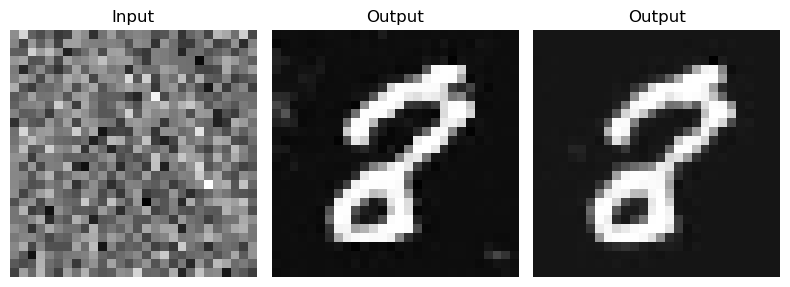

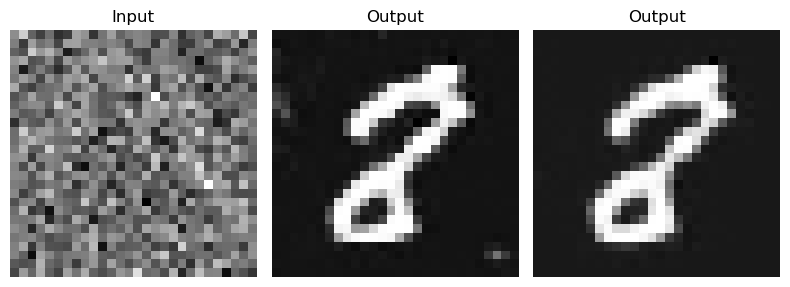

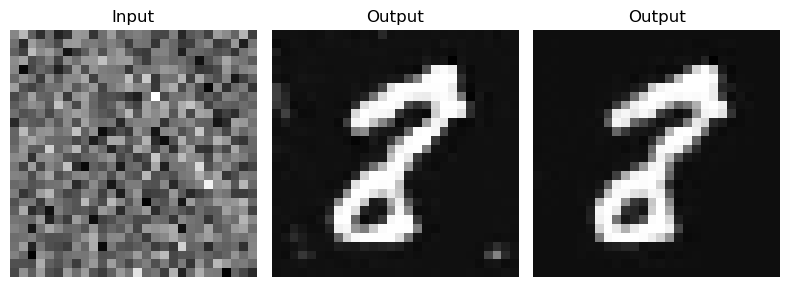

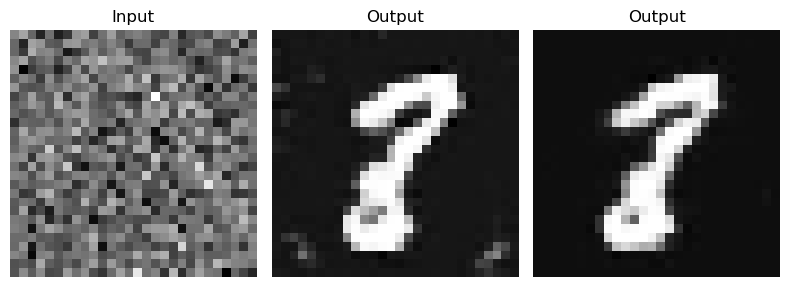

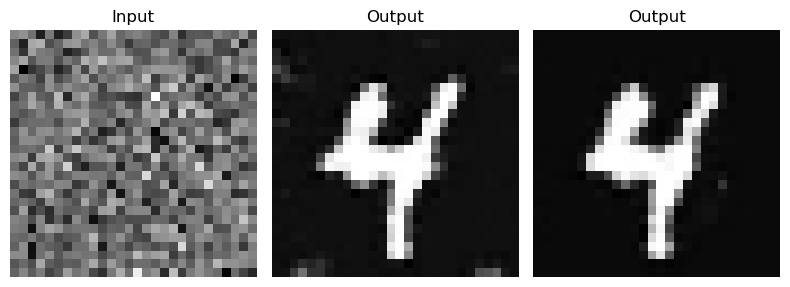

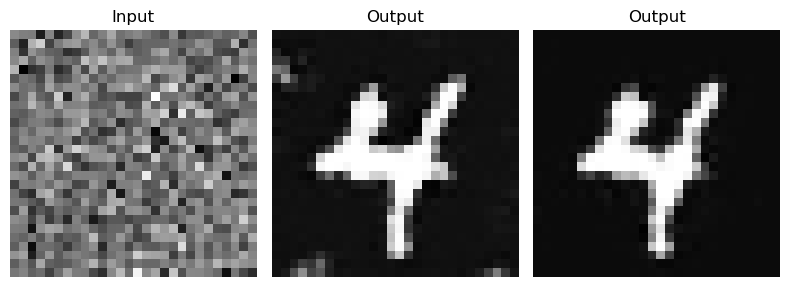

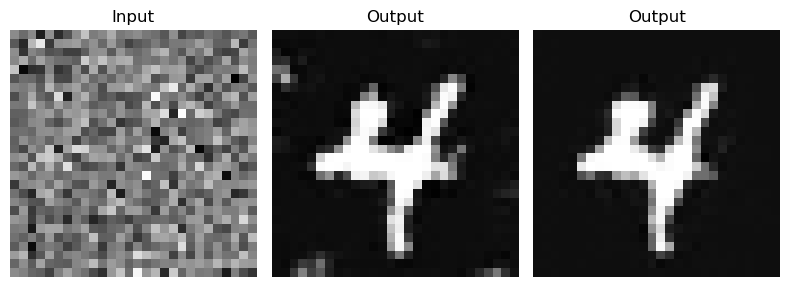

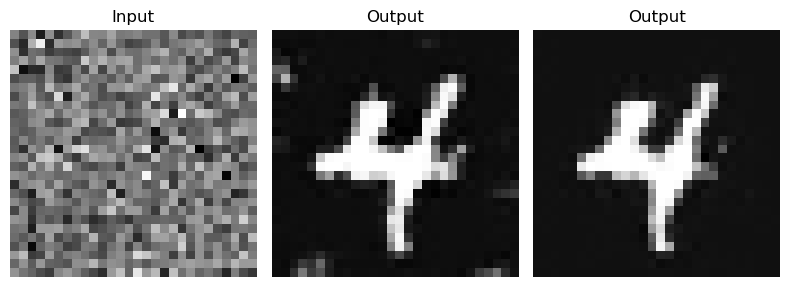

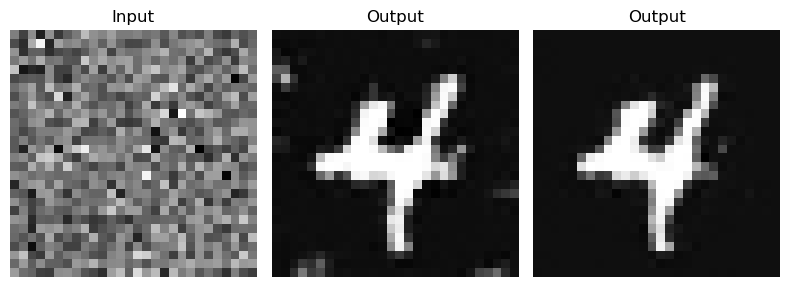

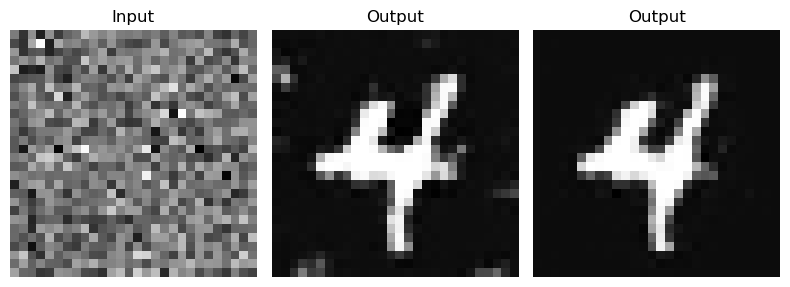

ModuleNotFoundError: No module named 'cv2'

In [487]:
## Generate images from the model
#print(f"noise shape before conv1: {noise.shape}")

#output = model(noise)

# output for interpolations
for i in range(num_interpolations):
    outputs[i] = model(interpolations[i])
    outputs2[i] = model(outputs[i])
    plot_generation(interpolations[i], outputs[i], outputs2[i], num_images=1)
    
## Save the generated images and create a movie
output_path = "/interpolation/input_images.pth"
images_to_movie(interpolations, output_path)

output_path = "/interpolation/output_images.mp4"
images_to_movie(outputs, output_path)

output_path = "output_images2.mp4"
images_to_movie(outputs2, output_path)

